# REMINDER: Remove API keys!

---
title: Open Source Observability for LangGraph
description: Learn how to use Langfuse for open source observability/tracing in your LangGraph application (Python).
category: Integrations
---

# Cookbook: LangGraph Integration


## What is LangGraph?

[LangGraph](https://langchain-ai.github.io/langgraph/) is an open-source framework for building complex, stateful, multi-agent applications using large language models (LLMs). LangGraph includes built-in persistence to save and resume state, which enables error recovery and human-in-the-loop workflows.

## What is this cookbook for?

This cookbook demonstrates how [Langfuse](https://langfuse.com/docs) helps to debug, analyze, and iterate on your LangGraph application using the [LangChain integration](https://langfuse.com/docs/integrations/langchain/tracing).

**By the end of this cookbook, you will be able to:**


*   Automatically trace LangGraph application via the Langfuse integration
*   Monitor advanced multi-agent setups
*   Add scores (like user feedback)
*   Manage your prompts used in LangGraph with Langfuse


## Initialize Langfuse
Initialize the Langfuse client with your [API keys](https://langfuse.com/faq/all/where-are-langfuse-api-keys) from the project settings in the Langfuse UI and add them to your environment.

In [ ]:
%pip install langfuse
%pip install langchain langgraph langchain_openai langchain_community

In [2]:
import os

# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-***"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-***"
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # for EU data region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # for US data region

# your openai key
os.environ["OPENAI_API_KEY"] = "***"

# Simple chat app with LangGraph
---

**What we will do in this section:**

*   Build a support chatbot in LangGraph that can answer common questions
*   Tracing the chatbot's input and output using Langfuse

We will start with a basic chatbot and build a more advanced multi agent setup in the next section, introducing key LangGraph concepts along the way.

Start by creating a `StateGraph`. A `StateGraph` object defines our chatbot's structure as a state machine. We will add nodes to represent the LLM and functions the chatbot can call, and edges to specify how the bot transitions between these functions.

In [3]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

# The chatbot node function takes the current State as input and returns an updated messages list. This is the basic pattern for all LangGraph node functions.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
graph_builder.add_node("chatbot", chatbot)

# Add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.set_entry_point("chatbot")

# Set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.set_finish_point("chatbot")

# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

## Add Langfuse as callback to the invocation

Now, we will add Langfuse handler as callback to trace the steps of our application:

`config={"callbacks": [langfuse_handler]}`

In [4]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

for s in graph.stream({"messages": [HumanMessage(content = "What is Langfuse?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)

{'chatbot': {'messages': [AIMessage(content='Langfuse is a tool designed to help developers monitor and observe the performance of their Large Language Model (LLM) applications. It provides detailed insights into how these applications are functioning, allowing for better debugging, optimization, and overall management. Langfuse offers features such as tracking key metrics, visualizing data, and identifying potential issues in real-time, making it easier for developers to maintain and improve their LLM-based solutions.', response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 13, 'total_tokens': 99}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-9a0c97cb-ccfe-463e-902c-5a5900b796b4-0', usage_metadata={'input_tokens': 13, 'output_tokens': 86, 'total_tokens': 99})]}}


## View traces in Langfuse

Example trace in Langfuse: https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/d109e148-d188-4d6e-823f-aac0864afbab


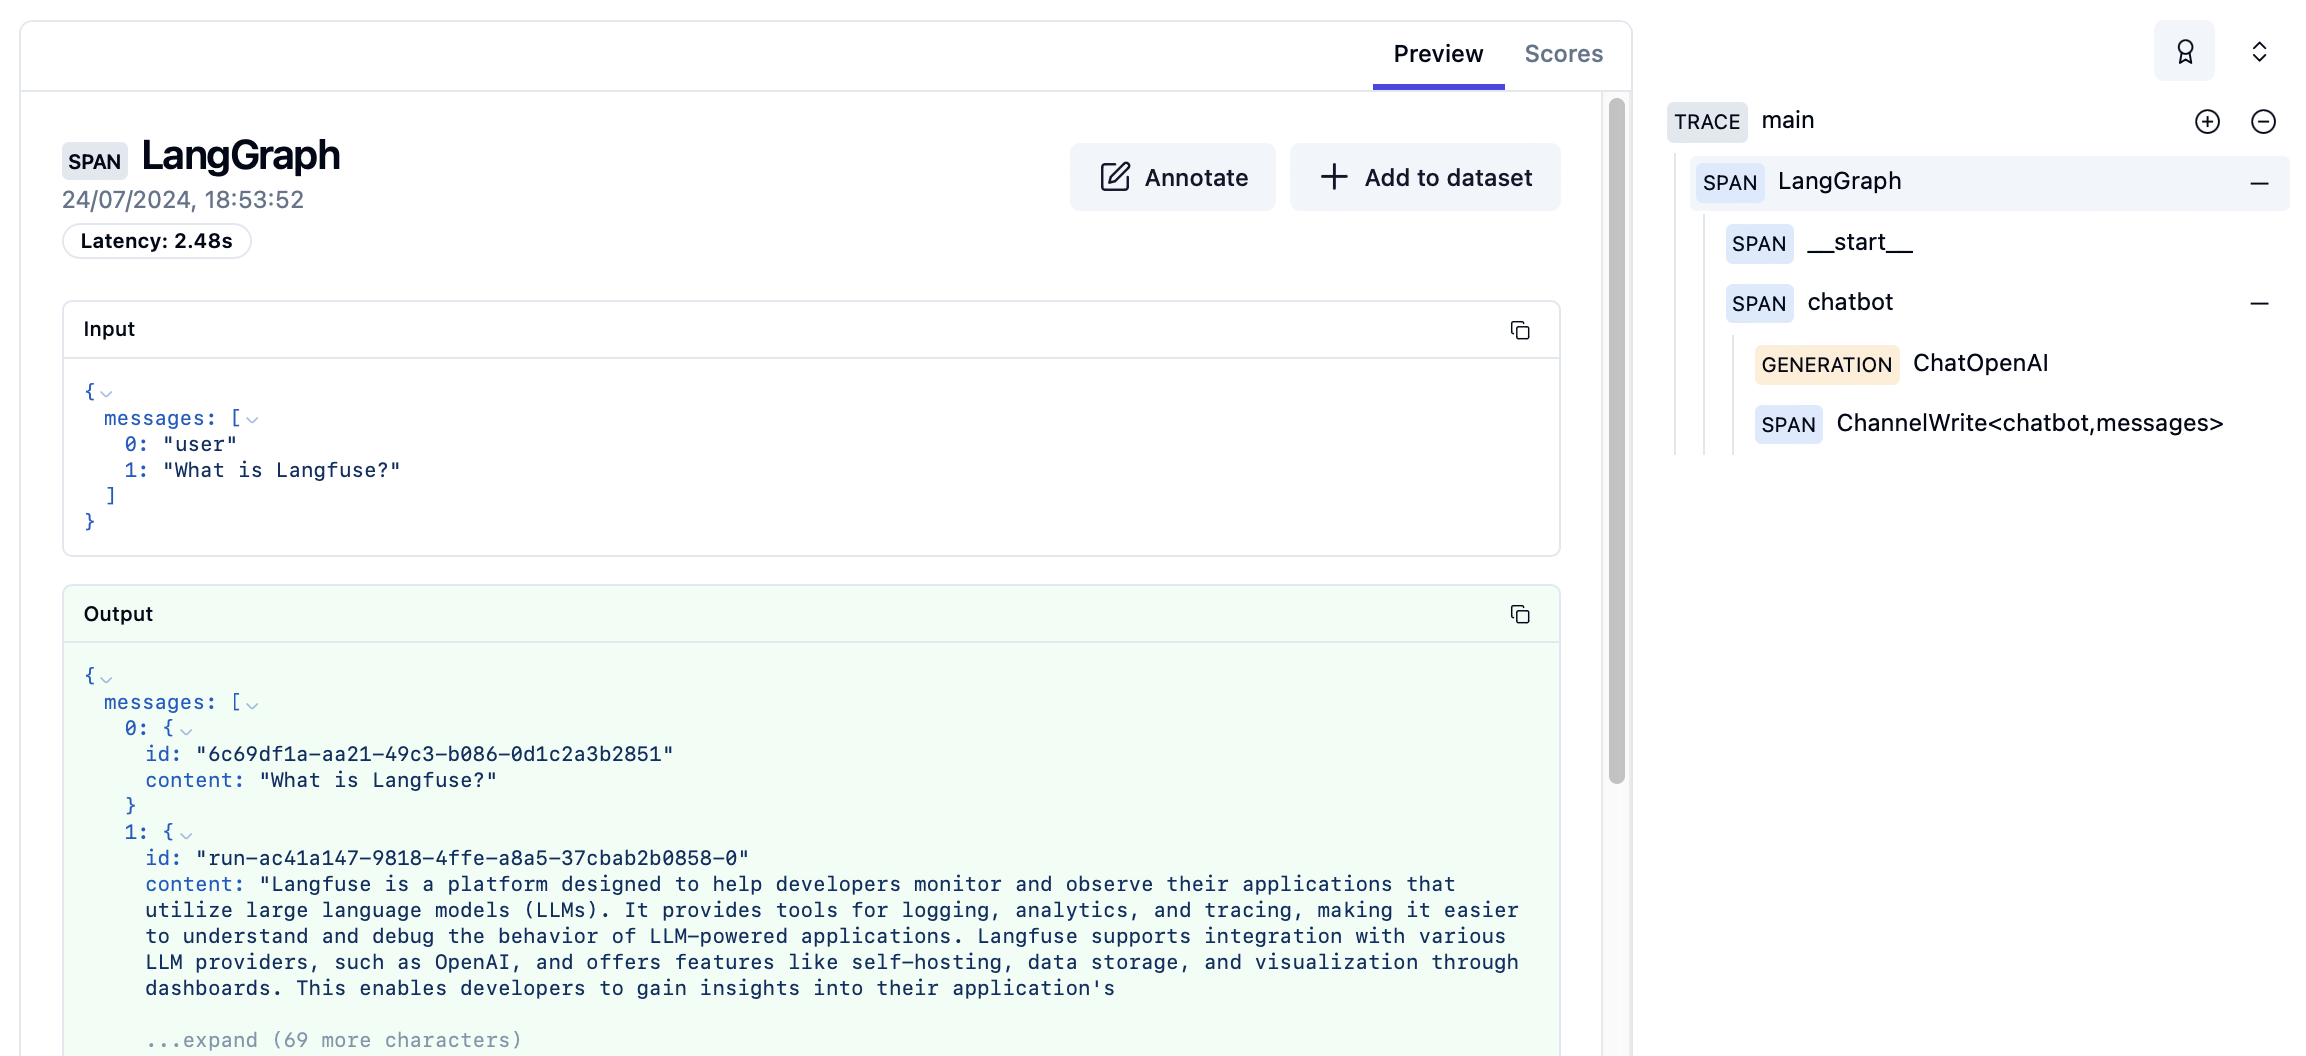

## Visualize the chat app

You can visualize the graph using the `get_graph` method along with a "draw" method

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

```mermaid
graph TD;
	__start__([__start__]):::first
	chatbot(chatbot)
	__end__([__end__]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
```

# Multi agent application with LangGraph
---

**What we will do in this section**:

*   Build 2 executing agents: One research agent using the LangChain WikipediaAPIWrapper to search Wikipedia and one that uses a custom tool to get the current time.
*   Build an agent supervisor to help delegate the user questions to one of the two agents
*   Add Langfuse handler as callback to trace the steps of the supervisor and executing agents

In [ ]:
%pip install langgraph langchain langchain_openai langchain_experimental pandas wikipedia

## Create tools

For this example, you build an agent to do wikipedia research, and one agent to tell you the current time. Define the tools they will use below:

In [7]:
from typing import Annotated

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langchain.tools import Tool

# Define a tools that searches Wikipedia
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

# Define a new tool that returns the current datetime
datetime_tool = Tool(
    name="Datetime",
    func = lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)

## Helper utilities

Define a helper function below to simplify adding new agent worker nodes.

In [8]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

## Create agent supervisor

It will use function calling to choose the next worker node OR finish processing.

In [9]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "CurrentTime"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed
options = ["FINISH"] + members

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

# Create the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

# Construction of the chain for the supervisor agent
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Construct graph

Now we are ready to start building the graph. Below, define the state and worker nodes using the function we just defined. Then we connect all the edges in the graph.

In [10]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# Add the research agent using the create_agent helper function
research_agent = create_agent(llm, "You are a web researcher.", [wikipedia_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Add the time agent using the create_agent helper function
currenttime_agent = create_agent(llm, "You can tell the current time at", [datetime_tool])
currenttime_node = functools.partial(agent_node, agent=currenttime_agent, name = "CurrentTime")

workflow = StateGraph(AgentState)

# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
workflow.add_node("Researcher", research_node)
workflow.add_node("CurrentTime", currenttime_node)
workflow.add_node("supervisor", supervisor_chain)

# We want our workers to ALWAYS "report back" to the supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.
# These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Add an entry point. This tells our graph where to start its work each time we run it.
workflow.add_edge(START, "supervisor")

# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph_2 = workflow.compile()

## Add Langfuse as callback to the invocation

Add Langfuse handler as callback: `config={"callbacks": [langfuse_handler]}`

You can use this integration in combination with the `observe()` decorator from the Langfuse Python SDK. Thereby, you can trace non-Langchain code, combine multiple Langchain invocations in a single trace, and use the full functionality of the Langfuse Python SDK.

In [11]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream({"messages": [HumanMessage(content = "How does photosynthesis work?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="Photosynthesis is a biological process by which photosynthetic organisms, such as most plants, algae, and cyanobacteria, convert light energy, usually from sunlight, into chemical energy. This energy is stored in the form of organic compounds like sugars, which fuel their metabolism.\n\n### Key Points of Photosynthesis:\n\n1. **Light Absorption**:\n    - The process begins when light energy is absorbed by reaction centers, which are proteins containing photosynthetic pigments (e.g., chlorophyll in plants).\n\n2. **Light-Dependent Reactions**:\n    - In these reactions, light energy is used to strip electrons from substances like water, producing oxygen gas.\n    - The hydrogen from water is used to create NADPH (reduced nicotinamide adenine dinucleotide phosphate) and ATP (adenosine triphosphate).\n\n3. **Light-Independent Reactions (Calvin Cycle)**:\n    - These reactions do not require ligh

In [12]:
# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream({"messages": [HumanMessage(content = "What time is it?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")

{'supervisor': {'next': 'CurrentTime'}}
----
{'CurrentTime': {'messages': [HumanMessage(content='The current time is 9:34 AM on July 25, 2024.', name='CurrentTime')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


## See traces in Langfuse

Example traces in Langfuse:

1. [How does photosynthesis work?](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/a8b0cc9e-da3b-485f-a642-35431a6f9289)
2. [What time is it?](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/ee5d5828-e983-4372-8e7f-04dfbe3e19d4)

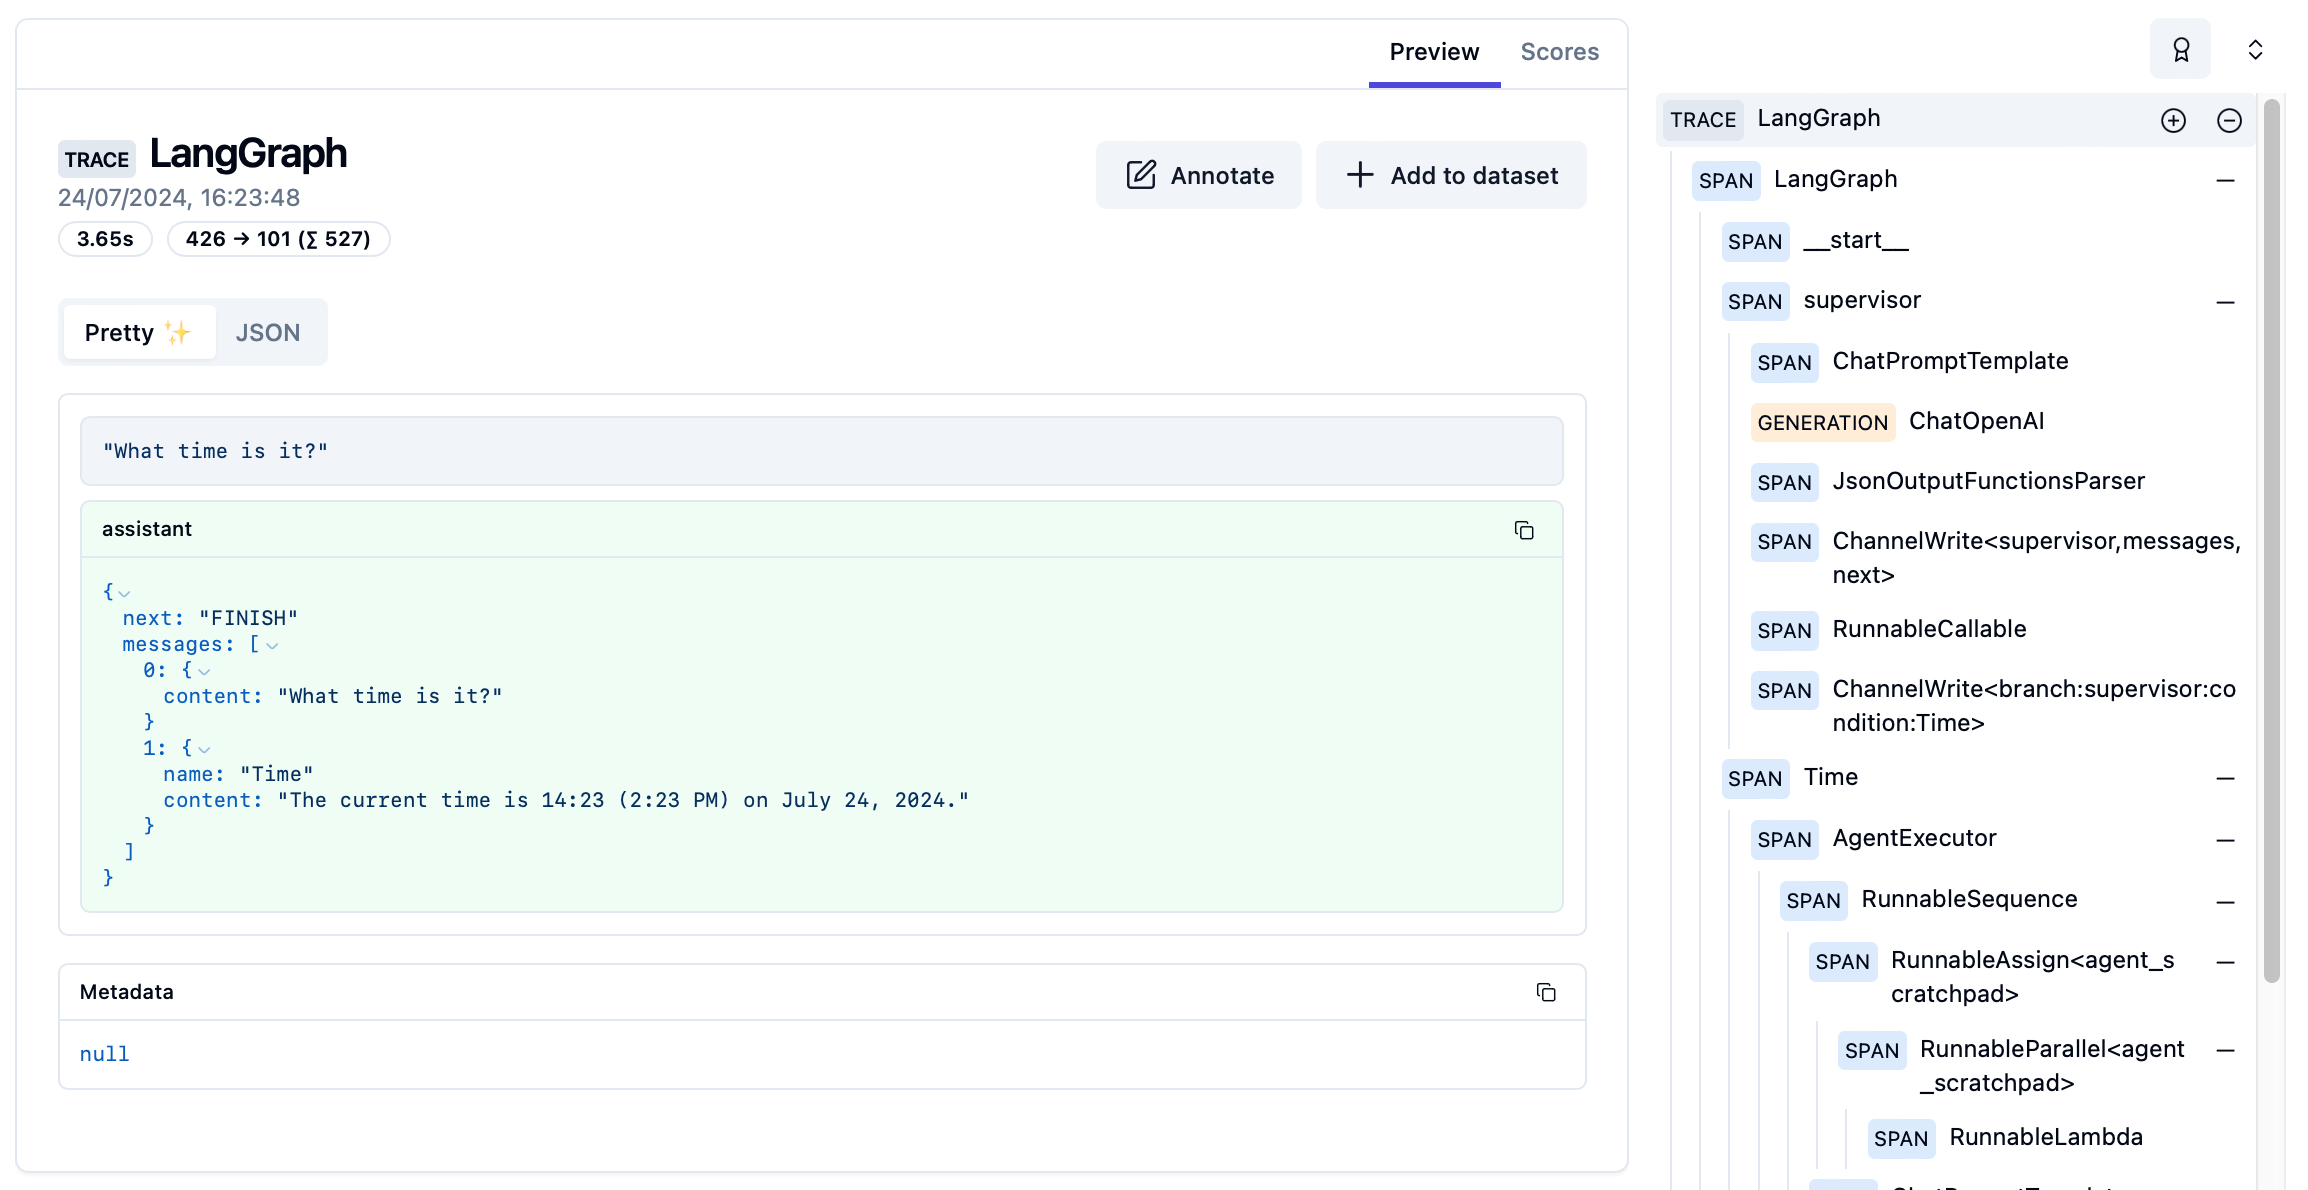

## Visualize the agent

You can visualize the graph using the `get_graph` method along with a "draw" method

In [ ]:
from IPython.display import Image, display
display(Image(graph_2.get_graph().draw_mermaid_png()))

```mermaid
graph TD;
	__start__([__start__]):::first
	Researcher(Researcher)
	CurrentTime(CurrentTime)
	supervisor(supervisor)
	__end__([__end__]):::last
	CurrentTime --> supervisor;
	Researcher --> supervisor;
	__start__ --> supervisor;
	supervisor -.-> Researcher;
	supervisor -.-> CurrentTime;
	supervisor -. &nbspFINISH&nbsp .-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc
```

# Adding scores to traces
---

[Scores](https://langfuse.com/docs/scores/overview) are used to evaluate single observations or entire traces. You can create them via our annotation workflow in the Langfuse UI, run model-based evaluation or ingest via the SDK as we do it in this example.

You can attach a score to the current observation context by calling `langfuse_context.score_current_observation`. You can also score the entire trace from anywhere inside the nesting hierarchy by calling `langfuse_context.score_current_trace`.

To get the context of the current observation, we use the `observe()` [decorator](https://langfuse.com/docs/sdk/python/decorators) and apply it to the `main()` function. By default it captures:

*   nesting via context vars
*   timings/durations
*   function name
*   args and kwargs as input dict
*   returned values as output

The decorator will automatically create a trace for the top-level function and spans for any nested functions.


In [28]:
from langfuse.decorators import langfuse_context, observe

# Langfuse observe() decorator to automatically create a trace for the top-level function and spans for any nested functions.
@observe()
def research_agent(user_message):
    # Get callback handler scoped to this observed function
    lf_handler = langfuse_context.get_current_langchain_handler()

    # Trace langchain run via the Langfuse CallbackHandler
    response = graph_2.invoke({"messages": [HumanMessage(content=user_message)]},
                        config={"callbacks": [lf_handler]})

    # Score the entire trace e.g. to add user feedback
    langfuse_context.score_current_trace(
        name = "user-explicit-feedback",
        value = 1,
        comment = "The time is correct!"
        )

    return response
research_agent("What time is it?")

{'messages': [HumanMessage(content='What time is it?'),
  HumanMessage(content='The current date and time is 2024-07-25T09:54:57.', name='CurrentTime')],
 'next': 'FINISH'}

## View trace with score in Langfuse

Example trace: https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/23338c52-350d-4efb-89ca-82d759828b1d

TODO: add image

# Manage prompts with Langfuse
---

Use [Langfuse prompt management](https://langfuse.com/docs/prompts/example-langchain) to effectively manage and version your prompts. We add the prompt used in this example via the SDK. In production, however, users would update and manage the prompts via the Langfuse UI instead of using the SDK.

Langfuse prompt management is basically a Prompt CMS (Content Management System). Alternatively, you can also edit and version the prompt in the Langfuse UI.



*   `Name` that identifies the prompt in Langfuse Prompt Management
*   Prompt with prompt template incl. `{{input variables}}`
*   `labels` to include `production` to immediately use prompt as the default

In this example, we create a system prompt for an assistant that translates every user message into Spanish.

In [15]:
from langfuse import Langfuse

# Initialize Langfuse client (prompt management)
langfuse = Langfuse()

langfuse.create_prompt(
    name="translator_system-prompt",
    prompt="You are a translator that translates every input text into Spanish. ",
    labels=["production"]
)

Prompt in Langfuse UI:

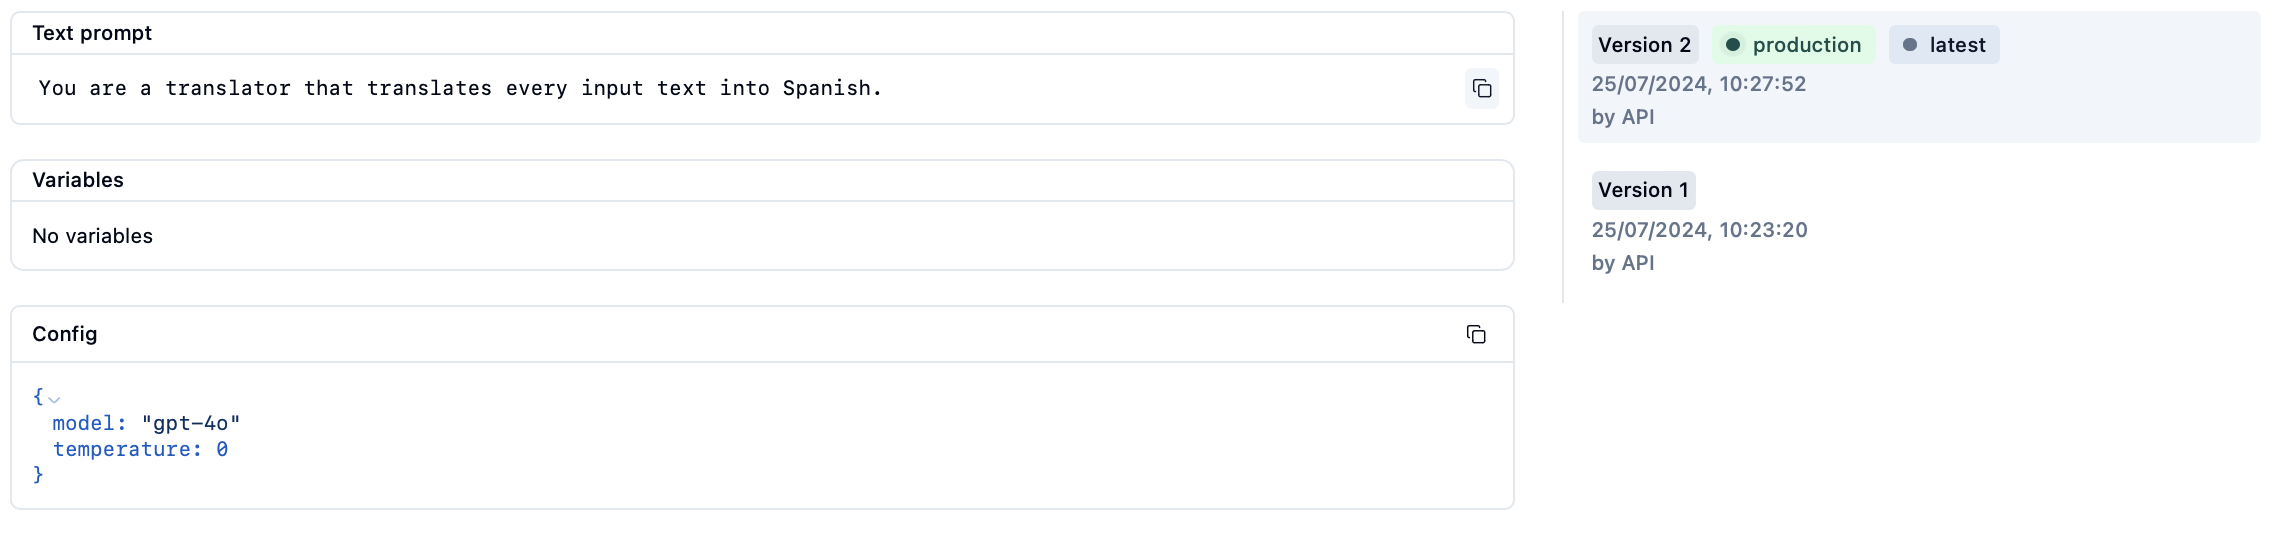

Use the utility method `.get_langchain_prompt()` to transform the Langfuse prompt into a string that can be used in Langchain.


**Context:** Langfuse declares input variables in prompt templates using double brackets (`{{input variable}}`). Langchain uses single brackets for declaring input variables in PromptTemplates (`{input variable}`). The utility method `.get_langchain_prompt()` replaces the double brackets with single brackets. In this example, however, we don't use any variables in our prompt.

In [16]:
# Get current production version of prompt and transform the Langfuse prompt into a string that can be used in Langchain
langfuse_system_prompt = langfuse.get_prompt("translator_system-prompt")
langchain_system_prompt = langfuse_system_prompt.get_langchain_prompt()

print(langchain_system_prompt)

You are a translator that translates every input text into Spanish. 


Now we can use the new system prompt string to update our assistant.

In [17]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

# Add the system prompt for our translator assistent
system_prompt = {
    "role": "system",
    "content": langchain_system_prompt
}

def chatbot(state: State):
    messages_with_system_prompt = [system_prompt] + state["messages"]
    response = llm.invoke(messages_with_system_prompt)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [18]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph.stream({"messages": [HumanMessage(content = "What is Langfuse?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)

{'chatbot': {'messages': [AIMessage(content='¿Qué es Langfuse?', response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 30, 'total_tokens': 36}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-1f419fe3-73e2-4413-aa6c-96560bbd09c8-0', usage_metadata={'input_tokens': 30, 'output_tokens': 6, 'total_tokens': 36})]}}


# Feedback
---

If you have any feedback or requests, please create a GitHub [Issue](https://langfuse.com/issue) or share your idea with the community on [Discord](https://langfuse.com/discord).